<a href="https://colab.research.google.com/github/luffystxr/week2/blob/main/Forest_Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-wildfire-dataset


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

In [23]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('✅ GPU is Available!')
else:
    print('❌ GPU is Unavailable!')

✅ GPU is Available!


In [24]:
# Define dataset directories using dynamic path from kagglehub
train_dir = "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/train"
val_dir = "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/val"
test_dir = "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test"

In [25]:
classes = os.listdir(train_dir)
num_classes = len(classes)
print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')

Number of Classes: 2
Classes: ['nofire', 'fire']


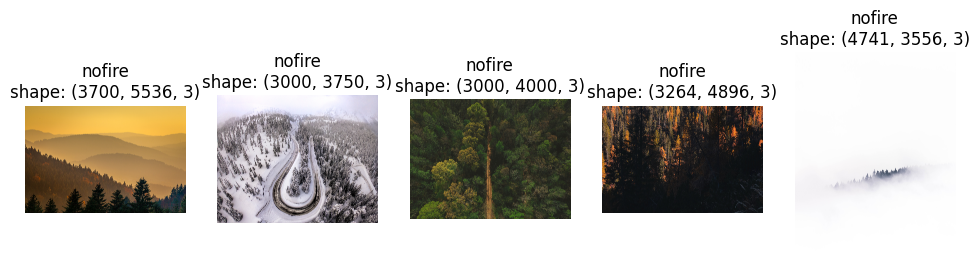

In [27]:
plt.figure(figsize=(12, 10))
for i in range(5):
    class_path = os.path.join(train_dir, classes[0])
    img_name = os.listdir(class_path)[i]
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'{classes[0]}\nshape: {img.shape}')
    plt.axis('off')
plt.show()

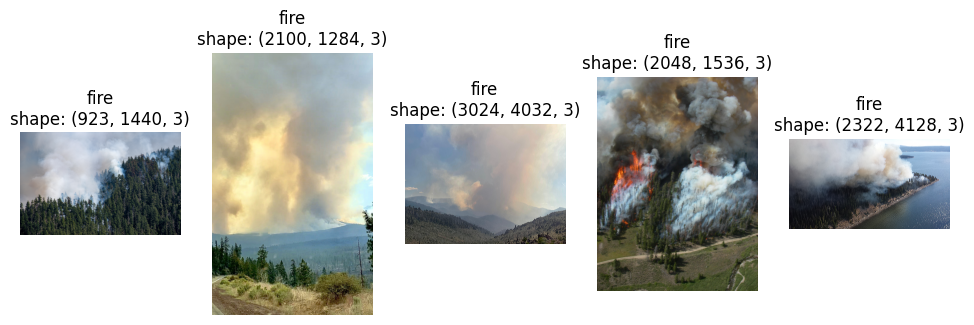

In [28]:
plt.figure(figsize=(12, 10))
for i in range(5):
    class_path = os.path.join(train_dir, classes[1])
    img_name = os.listdir(class_path)[i]
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'{classes[1]}\nshape: {img.shape}')
    plt.axis('off')
plt.show()

In [30]:
# Define image augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generators (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
img_width, img_height = 224, 224
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary', shuffle=True)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary', shuffle=True)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary', shuffle=True)

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [32]:
class_mapping = train_generator.class_indices
class_names = list(class_mapping.keys())
print("Class Names:", class_names)

Class Names: ['fire', 'nofire']


In [33]:
# Load MobileNetV3Large with pre-trained weights
base_model = MobileNetV3Large(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')

# Freeze all layers of the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [35]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,275,393 (12.49 MB)

 Trainable params: 279,041 (1.06 MB)

 Non-trainable params: 2,996,352 (11.43 MB)